In [ ]:
# The following code is based on https://github.com/jjlira/nlp-with-transformers-tunstall Notebook: 02_classification.ipynb
# I have also adopted some changes and additions from apl. Prof. Dr. Wiebke Petersen from the course Transformer Modelle (SoSe23) at the Heinrich-Heine-University Düsseldorf

In [ ]:
!pip install -U accelerate
!pip install -U transformers
!pip install datasets
!pip install umap-learn

In [ ]:
import sys
import urllib
import datasets
import matplotlib.pyplot as plt
import torch
import transformers
import numpy as np
import pandas as pd

### Loading and preparing the dataset

In [ ]:
from datasets import load_dataset
compounds = load_dataset("csv", data_files="only_translation_relation.txt", sep=";", names=["text", "label"])

In [ ]:
compounds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 843
    })
})

In [ ]:
compounds["train"].features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='string', id=None)}

In [ ]:
compounds = compounds.class_encode_column("label")

In [ ]:
compounds["train"]["label"][:5]

[0, 0, 5, 5, 2]

In [ ]:
print(compounds["train"].features)
print(compounds["train"][0])

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['ABOUT', 'ACTOR', 'BE', 'HAVE', 'IN', 'INST'], id=None)}
{'text': 'Overall grade in the baccalaureate', 'label': 0}


In [ ]:
compounds = compounds["train"].train_test_split(shuffle=True,test_size=0.1)
compounds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 758
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 85
    })
})

In [ ]:
compounds["train"]["label"][:5]

[5, 2, 5, 3, 3]

### From datasets to dataFrames

In [ ]:
compounds.set_format(type="pandas")
df = compounds["train"][:]
df.head()

,text,label
0,"Awning, sun sail",5
1,Surface of a wall,2
2,Gymnastics exercise in which someone stands on...,5
3,soup made from pumpkin,3
4,Convent of the Franciscans or Franciscan nuns,3


In [ ]:
def label_int2str(row):
    return compounds["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,"Awning, sun sail",5,INST
1,Surface of a wall,2,BE
2,Gymnastics exercise in which someone stands on...,5,INST
3,soup made from pumpkin,3,HAVE
4,Convent of the Franciscans or Franciscan nuns,3,HAVE


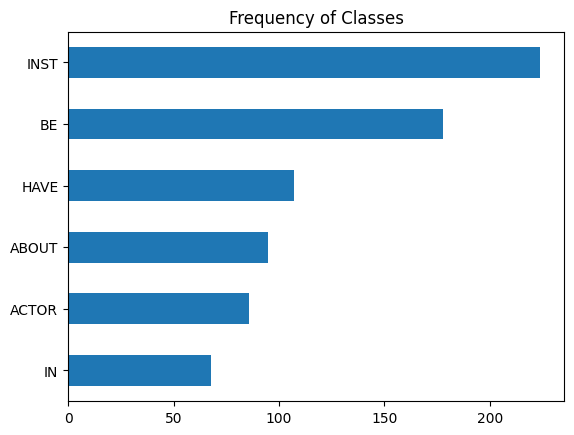

In [ ]:
# Class distribution
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [ ]:
compounds.reset_format()

### Tokenization

In [ ]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
tokenizer.vocab_size

30522

and the corresponding model's maximum context size:

In [ ]:
tokenizer.model_max_length

512

Another interesting attribute to know about is the names of the fields that the model expects in its forward pass:

In [ ]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [ ]:
# Tokenize the whole dataset
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [ ]:
compounds_encoded = compounds.map(tokenize, batched=True, batch_size=None)

In [ ]:
print(compounds_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']



## Training a text classifier and using a pretrained transformer model to extract features

In [ ]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [ ]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [ ]:
compounds_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

In [ ]:
compounds_hidden = compounds_encoded.map(extract_hidden_states, batched=True)

In [ ]:
compounds_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [ ]:
X_train = np.array(compounds_hidden["train"]["hidden_state"])
X_test = np.array(compounds_hidden["test"]["hidden_state"])
y_train = np.array(compounds_hidden["train"]["label"])
y_test = np.array(compounds_hidden["test"]["label"])
X_train.shape, X_test.shape

((758, 768), (85, 768))

#### Visualizing the training set

In [ ]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,5.642619,10.267431,5
1,6.592567,9.030785,2
2,6.000015,12.085505,5
3,3.094371,8.736118,3
4,6.151538,10.424618,3


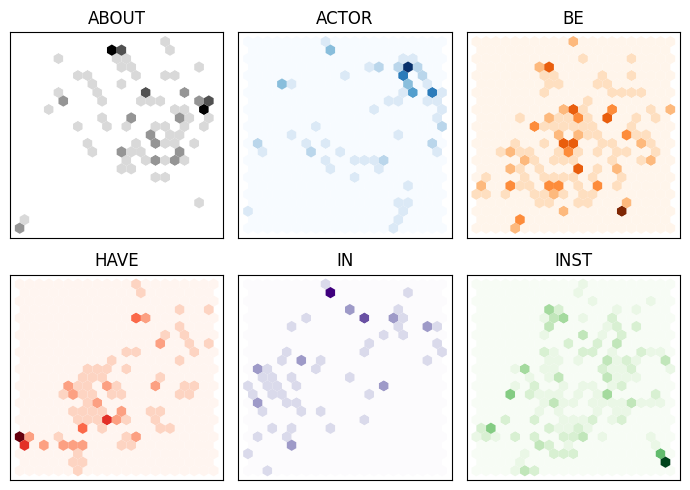

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"] # sind nur 6
labels = compounds["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

#### Training a logistic regression classifier


In [ ]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

In [ ]:
lr_clf.score(X_test, y_test)

0.5411764705882353

Using a dummy classifier to compare the accuracy

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_test, y_test)

0.29411764705882354

In [ ]:
dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_test, y_test)

0.1411764705882353

In [ ]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_test, y_test)

0.25882352941176473

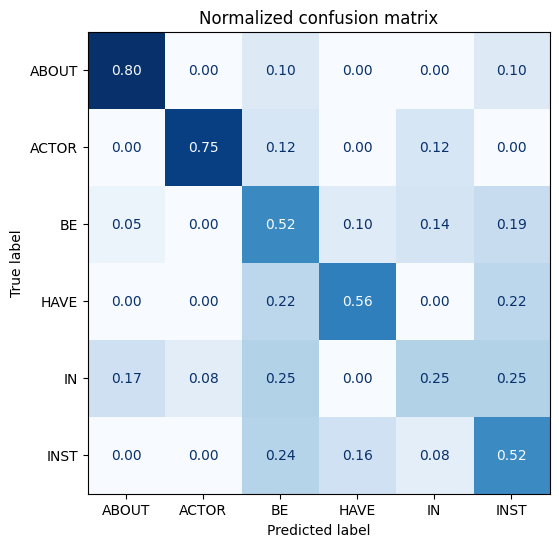

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_test) # valid zu test
plot_confusion_matrix(y_preds, y_test, labels)

## Fine-Tuning a pretrained transformer model

In [ ]:
from transformers import AutoModelForSequenceClassification
num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

#### Training the model

In [ ]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.33.2', '0.23.0')

In [ ]:
compounds_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 758
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 85
    })
})

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 32
logging_steps = len(compounds_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-compounds"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=65,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  log_level="error")

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=compounds_encoded["train"],
                  eval_dataset=compounds_encoded["test"],
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.713600,1.654376,0.294118,0.133690
2,1.562000,1.507929,0.458824,0.355991
3,1.352800,1.355828,0.517647,0.445712
4,1.139400,1.269538,0.529412,0.482965
5,0.913100,1.226274,0.564706,0.516478
6,0.712600,1.260785,0.517647,0.477855
7,0.516500,1.280116,0.541176,0.519476
8,0.341500,1.348308,0.529412,0.501998
9,0.264800,1.432307,0.517647,0.500709
10,0.183700,1.550661,0.505882,0.492469


In [ ]:
preds_output = trainer.predict(compounds_encoded["test"])

In [ ]:
preds_output.metrics

{'test_loss': 2.598376512527466,
 'test_accuracy': 0.5411764705882353,
 'test_f1': 0.5515585306288081,
 'test_runtime': 0.0964,
 'test_samples_per_second': 882.172,
 'test_steps_per_second': 31.135}

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

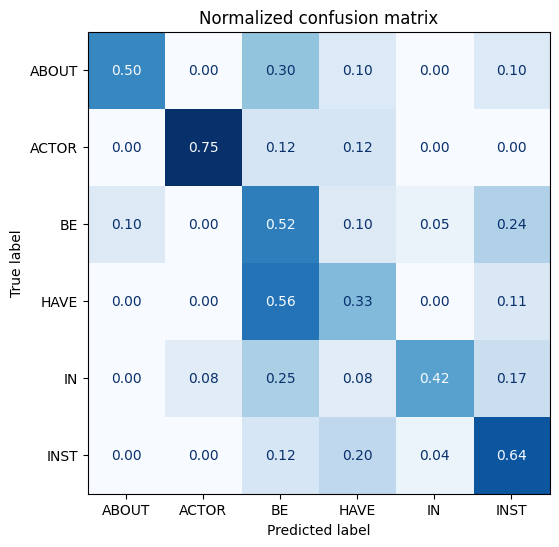

In [ ]:
plot_confusion_matrix(y_preds, y_test, labels)

#### Error analysis

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [ ]:
compounds_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

compounds_encoded["test"] = compounds_encoded["test"].map(
    forward_pass_with_label, batched=True, batch_size=16)

In [ ]:
compounds_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = compounds_encoded["test"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [ ]:
df_test.sort_values("loss", ascending=False)

,text,label,predicted_label,loss
80,Stand at which information is provided about s...,HAVE,INST,9.021534
57,system formed by the sun and the celestial bod...,HAVE,BE,8.617360
65,old field dimension,IN,BE,8.555410
67,"Man-made and therefore imperfect, transient th...",ACTOR,BE,8.475693
72,"Position, employment",IN,BE,8.389558
...,...,...,...,...
33,Plant for the production of electrical energy,INST,INST,0.000764
6,Ability to make a decision,INST,INST,0.000740
42,Opportunity to purchase,INST,INST,0.000720
39,the responsiveness,INST,INST,0.000690


In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
80,Stand at which information is provided about s...,HAVE,INST,9.021534
57,system formed by the sun and the celestial bod...,HAVE,BE,8.617360
65,old field dimension,IN,BE,8.555410
67,"Man-made and therefore imperfect, transient th...",ACTOR,BE,8.475693
72,"Position, employment",IN,BE,8.389558
28,Group of organisms that depend on each other i...,HAVE,BE,8.174122
12,"Stage play of serious content, which has a pos...",BE,INST,8.092082
78,Communication by means of signs,BE,INST,8.058887
51,Disturbance of the TV picture,INST,BE,8.003187
77,Hair stock,INST,HAVE,7.881220


In [ ]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
84,Plant in which cement is produced,INST,INST,0.000688
39,the responsiveness,INST,INST,0.000690
42,Opportunity to purchase,INST,INST,0.000720
6,Ability to make a decision,INST,INST,0.000740
33,Plant for the production of electrical energy,INST,INST,0.000764
69,"Beach as it is dreamed, longed for",BE,BE,0.000785
16,masonry structure,BE,BE,0.000788
1,juice made from grapes,INST,INST,0.000806
38,"Land as it is longed for, dreamed of",BE,BE,0.000821
31,Ability to concentrate,INST,INST,0.000832
